In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/Shareddrives/Skripsi/dataset/split.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split/reptiles/train/crocodile/nile_crocodile_s_001696.png  
  inflating: split/reptiles/train/crocodile/crocodylus_porosus_s_000144.png  
  inflating: split/reptiles/train/crocodile/nile_crocodile_s_000215.png  
  inflating: split/reptiles/train/crocodile/crocodylus_porosus_s_000265.png  
  inflating: split/reptiles/train/crocodile/crocodylus_porosus_s_000461.png  
  inflating: split/reptiles/train/crocodile/crocodylus_porosus_s_000048.png  
  inflating: split/reptiles/train/crocodile/crocodylus_niloticus_s_000557.png  
  inflating: split/reptiles/train/crocodile/nile_crocodile_s_000990.png  
  inflating: split/reptiles/train/crocodile/crocodile_s_000791.png  
  inflating: split/reptiles/train/crocodile/crocodile_s_000028.png  
  inflating: split/reptiles/train/crocodile/crocodile_s_003028.png  
  inflating: split/reptiles/train/crocodile/nile_crocodile_s_000037.png  
  inflating: split/reptiles/train/crocodile/african_cr

In [4]:
import PIL
import cv2
from PIL import Image
DIM=32
def randomcrop(img):
    dim = img.shape
    resized = cv2.resize(img, (int(dim[1]*DIM/dim[0]),int(dim[0]*DIM/dim[0])), interpolation = cv2.INTER_AREA)
    resized=tf.image.random_crop(resized,seed=1, size=(DIM,DIM,3))
    resized=np.array(resized)
    return resized

In [5]:
SEED=42
train_dir='/content/split/insects/train'
val_dir='/content/split/insects/val'


img_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # preprocessing_function=randomcrop,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
)
val_img_gen = ImageDataGenerator(
    rescale=1./255,
)
coarse_train_gen=img_gen.flow_from_directory(
    train_dir,
    target_size=(DIM, DIM),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)
coarse_val_gen=val_img_gen.flow_from_directory(
    val_dir,
    target_size=(DIM, DIM),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)


Found 2400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


(32, 32, 32, 3)
(32, 32, 3)


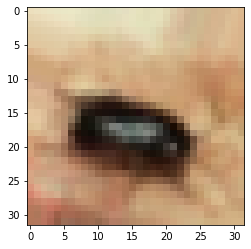

In [6]:
batches=next(coarse_train_gen)  # returns the next batch of images and labels 
print(batches[0].shape) # batch[0] is the images, batch[1] are the labels
img=batches[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.imshow(img)   # shows the first image

In [7]:
from keras.applications import VGG16, VGG19, MobileNetV2

In [8]:
# base_model=MobileNetV2(classes=50, weights='imagenet', include_top=False, input_shape=(DIM,DIM,3))
base_model=VGG16(weights='imagenet', include_top=False, input_shape=(DIM,DIM,3))

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [9]:
count=0
for layer in base_model.layers[:11]:
    # print(count,layer)
    # count+=1
    layer.trainable = False
# print(count)

In [10]:
model=keras.Sequential([
    base_model,
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(512,activation='relu'),
    layers.Dense(5,activation='softmax')
])

In [11]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14,979,909
Trainable params: 13,244,421
No

In [12]:
from keras.optimizers import Adam
import keras.backend as K
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

    def precision(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',f1_score])

In [14]:
earlystop=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

In [15]:
validation_steps=600//32
history1=model.fit(coarse_train_gen,
          validation_data=coarse_val_gen,
          epochs=100,
          validation_steps=validation_steps,
          verbose=1,
          callbacks=[earlystop]
          )

Epoch 1/100


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


75/75 [==============================] - 14s 48ms/step - loss: 1.2155 - accuracy: 0.5092 - f1_score: 0.3989 - val_loss: 0.9189 - val_accuracy: 0.6632 - val_f1_score: 0.6317
Epoch 2/100
75/75 [==============================] - 3s 41ms/step - loss: 0.9029 - accuracy: 0.6617 - f1_score: 0.6340 - val_loss: 0.8127 - val_accuracy: 0.6910 - val_f1_score: 0.7003
Epoch 3/100
75/75 [==============================] - 4s 56ms/step - loss: 0.8458 - accuracy: 0.6875 - f1_score: 0.6673 - val_loss: 0.7614 - val_accuracy: 0.7205 - val_f1_score: 0.7021
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 0.7852 - accuracy: 0.7067 - f1_score: 0.6901 - val_loss: 0.7616 - val_accuracy: 0.7222 - val_f1_score: 0.7138
Epoch 5/100
75/75 [==============================] - 3s 41ms/step - loss: 0.6770 - accuracy: 0.7504 - f1_score: 0.7390 - val_loss: 0.7162 - val_accuracy: 0.7517 - val_f1_score: 0.7355
Epoch 6/100
75/75 [==============================] - 3s 39ms/step - loss: 0.6470 - accuracy

In [16]:
base_model.trainable=True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',f1_score])

validation_steps=600//32
history2 = model.fit(coarse_train_gen,
          validation_data=coarse_val_gen,
          epochs=100,
          validation_steps=validation_steps,
          verbose=1,
          callbacks=[earlystop]
          )

Epoch 1/100
75/75 [==============================] - 6s 58ms/step - loss: 0.2303 - accuracy: 0.9212 - f1_score: 0.9209 - val_loss: 0.6229 - val_accuracy: 0.8212 - val_f1_score: 0.8222
Epoch 2/100
75/75 [==============================] - 3s 41ms/step - loss: 0.2163 - accuracy: 0.9229 - f1_score: 0.9222 - val_loss: 0.6639 - val_accuracy: 0.8073 - val_f1_score: 0.8084
Epoch 3/100
75/75 [==============================] - 3s 42ms/step - loss: 0.1865 - accuracy: 0.9308 - f1_score: 0.9311 - val_loss: 0.6333 - val_accuracy: 0.8229 - val_f1_score: 0.8244
Epoch 4/100
75/75 [==============================] - 4s 55ms/step - loss: 0.1648 - accuracy: 0.9413 - f1_score: 0.9411 - val_loss: 0.7602 - val_accuracy: 0.8021 - val_f1_score: 0.8016
Epoch 5/100
75/75 [==============================] - 3s 41ms/step - loss: 0.1760 - accuracy: 0.9342 - f1_score: 0.9357 - val_loss: 0.6912 - val_accuracy: 0.8142 - val_f1_score: 0.8160
Epoch 6/100
75/75 [==============================] - 3s 42ms/step - loss: 0.1787

In [17]:
model.save('insects.h5')

In [18]:
!cp 'insects.h5' "/content/drive/Shareddrives/Skripsi/model/f1"

In [19]:
def display_history(history, metric='accuracy'):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_{}'.format(metric)])
  plt.title('model {}'.format(metric))
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()



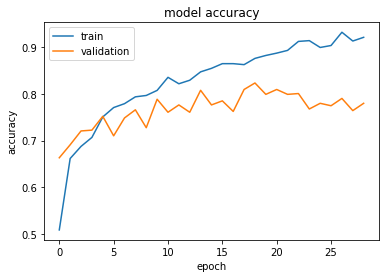

In [20]:

display_history(history1, 'accuracy')



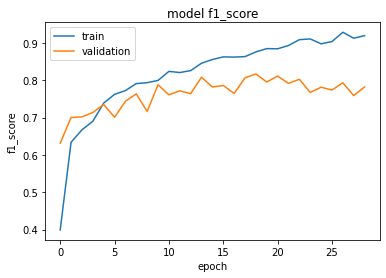

In [21]:


display_history(history1, 'f1_score')

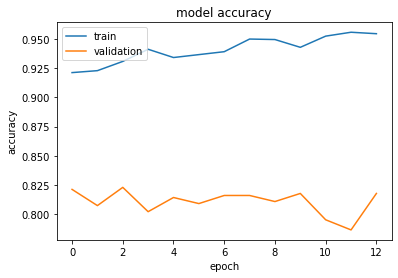

In [22]:
display_history(history2, 'accuracy')


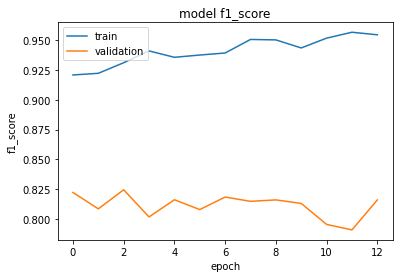

In [23]:
display_history(history2, 'f1_score')
